# Knobs to turn

In this session we will learn about different models of ballot generator, and what "knobs" each model has that we can turn to change voter behavior. 


## Generating Profiles

There are many models for generating ballots available to us, and some of these models have different knobs we can turn to model different voter behaviors. Here is how we can implement some of these models in VoteKit.

### A model with one knob

Just for a point of comparison, we will introduce the "Impartial Culture" model. This model says that when a voter goes to cast a ranked-ballot, they do so by randomly choosing one out of all of the possible rankings (uniform over the set of permutations for you probabilty folk). That's it. There is only one knob to turn---the number of candidates---, and no way to change the behavior of the voters. They all vote randomly.

This model might not be very realistic, but it is very easy to use and prove theorems about, so it abounds in the academic literature. We don't think it's wise to use in case studies of real-world jurisdiction. We just wanted to show you that some models have fewer knobs!

In [1]:
from votekit.ballot_generator import ImpartialCulture
from votekit.pref_profile import profile_df_head

# the only thing you have to do is choose the candidates

# Type a list of 3 candidate names
candidates = ["Chris", "Moon", "Peter"]
ic_bg = ImpartialCulture(candidates = candidates)

# choose the number of ballots you want to generate
profile = ic_bg.generate_profile(1000)

If there are 3 candidates, there are 6 possible rankings. Since the Impartial Culture model has voters vote randomly, we should expect to see about equal numbers of each ballot type in the generated profile.

In [2]:
profile_df_head(profile, n=6) # prints the profile in decreasing order of weight

,Ranking_1,Ranking_2,Ranking_3,Voter Set,Weight
Ballot Index,,,,,
1,(Moon),(Chris),(Peter),{},177
5,(Chris),(Moon),(Peter),{},175
0,(Chris),(Peter),(Moon),{},172
2,(Peter),(Chris),(Moon),{},168
4,(Peter),(Moon),(Chris),{},157
3,(Moon),(Peter),(Chris),{},151


Try it yourself: change the number of ballots generated above. The more ballots you generate the closer to the same number of each ballot you should get. Try changing the candidate names or even the number of candidates.

### A model with knobs

The slate-Plackett-Luce (sPL) model models "impulsive" voters. These are voters who rank their candidates only by considering how much they like each individual candidate. Later we will see a model for "deliberative" voters. Both use the same set up, so we will focus on sPL first.

Knob 1: Number of blocs 

The first parameter we need to decide is the voting blocs. This could be Democract/Republican, White/POC, or some other breakdown of the voters. You aren't limited to just two blocs, although the number of parameters ends up growing a LOT when you start adding more blocs, so we will stick with two for now.

Knob 2: Size of blocs

The second parameter we need to decide is the relative size of each bloc. 

What can turning these knobs model? 

These knobs are useful for keeping track of a voting bloc of interest, and measuring the impact of low/high turnout of groups.

In [3]:
from votekit.ballot_generator import slate_PlackettLuce

bloc_voter_prop = {"X": .8, "Y": .2}

Knob 3: Number of candidates

For each bloc of voters, we need to decide how many candidates are in their slate. This knob is useful for understanding the impacts of a crowded or sparse field of candidates. Think "vote splitting."

In [4]:
slate_to_candidates = {"X": ["Chris", "Peter", "Jeanne"],
                        "Y": ["Moon", "Mala"]}

Knob 4: Bloc cohesion

For each bloc of voters, we need to decide how cohesive they are. Think of cohesion as polarization. If cohesion is 1, it means that every voter ranks all of their own candidates above all of the others. If cohesion is 1/2, this means that a voter tends to rank one candidate from their own slate, then a candidate from the other slate, and back and forth.

In [5]:
# the values of .9 indicate that these blocs are highly polarized;
# they prefer their own candidates much more than the opposing slate
cohesion_parameters = {
    "X": {"X":.9, "Y":.1},
    "Y": {"X":.1, "Y":.9},
    }



Knob 5: Candidate strength

The final knob to turn is the candidate strength knob. This is a number between 0 and infinity. The smaller the number, the more a strong candidate emerges. That is, the bloc of voters prefers a single candidate.
The larger the number, the more uniform candidate strength becomes. That is, the bloc of voters tends to prefer all candidates similarly.
If the number is 1, all bets are off!

Technically, these parameters are known as "Dirichlet alpha" values. You don't need to know what that means (although you can read about it [here](https://votekit.readthedocs.io/en/latest/social_choice_docs/scr/#dirichlet-distribution)), but that explains why we name the variable `alphas`.

This knob is good for modeling how the strength of candidates can impact an election. What if a candidate receives an endorsement? What if there is an incumbent candidate with strong support? What if the candidates are all equally matched?

In [6]:
alphas = {
    "X": {"X":100, "Y":1}, # the X block has uniform preference for their candidates, and unknown for the Y candidates
    "Y": {"X":1, "Y":.1}, # the Y block has strong preference for one of their candidates, and unknown for the X candidates
    }

Finally, we are ready to create the ballot generator.

In [7]:
pl = slate_PlackettLuce.from_params(slate_to_candidates=slate_to_candidates,
          bloc_voter_prop=bloc_voter_prop,
          cohesion_parameters=cohesion_parameters,
          alphas=alphas)

We can generate ballots in the same way as before.

In [8]:
profile = pl.generate_profile(1000)
profile_df_head(profile, n=10) # prints the profile in decreasing order of weight

,Ranking_1,Ranking_2,Ranking_3,Ranking_4,Ranking_5,Voter Set,Weight
Ballot Index,,,,,,,
30,(Peter),(Chris),(Jeanne),(Mala),(Moon),{},103
26,(Peter),(Jeanne),(Chris),(Mala),(Moon),{},90
0,(Chris),(Jeanne),(Peter),(Mala),(Moon),{},87
70,(Mala),(Moon),(Chris),(Jeanne),(Peter),{},87
4,(Chris),(Peter),(Jeanne),(Mala),(Moon),{},85
17,(Jeanne),(Chris),(Peter),(Mala),(Moon),{},83
14,(Jeanne),(Peter),(Chris),(Mala),(Moon),{},73
68,(Mala),(Moon),(Jeanne),(Chris),(Peter),{},39
71,(Mala),(Moon),(Chris),(Peter),(Jeanne),{},32


Do the top 10 ballots make sense given our parameters? The top few ballots should be X bloc voters whose top candidates are Peter, Chris, and Jeanne. The X bloc has uniform preference over their candidates. The Y bloc has strong preference for one candidate, so their ballots should mostly rank Moon over Mala or Mala over Moon (the randomization does not let us know which of the candidates will be strong).

Actually, it can be hard to tell which ballots come from which bloc of voters. Let's regenerate a profile but split the ballots by bloc.

In [9]:
profiles_by_bloc, complete_profile = pl.generate_profile(1000, by_bloc = True)

for bloc, profile in profiles_by_bloc.items():
    print(f"This is the top ten ballots of the profile for bloc {bloc}.")
    print(profile_df_head(profile, n=10).to_string())
    print()

print("This is the complete profile.")
print(profile_df_head(complete_profile, n=10).to_string())

This is the top ten ballots of the profile for bloc X.
             Ranking_1 Ranking_2 Ranking_3 Ranking_4 Ranking_5 Voter Set Weight
Ballot Index                                                                   
8              (Peter)   (Chris)  (Jeanne)    (Mala)    (Moon)        {}    101
27            (Jeanne)   (Peter)   (Chris)    (Mala)    (Moon)        {}     89
32             (Chris)  (Jeanne)   (Peter)    (Mala)    (Moon)        {}     85
19            (Jeanne)   (Chris)   (Peter)    (Mala)    (Moon)        {}     82
3              (Peter)  (Jeanne)   (Chris)    (Mala)    (Moon)        {}     82
41             (Chris)   (Peter)  (Jeanne)    (Mala)    (Moon)        {}     79
40             (Chris)   (Peter)  (Jeanne)    (Moon)    (Mala)        {}     17
7              (Peter)   (Chris)  (Jeanne)    (Moon)    (Mala)        {}     17
2              (Peter)  (Jeanne)   (Chris)    (Moon)    (Mala)        {}     15
26            (Jeanne)   (Peter)   (Chris)    (Moon)    (Mala)   

Now do the top 10 ballots make sense given our parameters? The top ballots from the X bloc should be voters whose top candidates are Peter, Chris, and Jeanne. The X bloc has uniform preference over their candidates. The Y bloc has strong preference for one candidate, so their ballots should mostly rank Moon over Mala or Mala over Moon.

Try it yourself:

Edit the code below to explore how changing the different knobs allows you to model different voter behavior. One at a time, try the following prompts.

1) Try changing the bloc sizes to model low turnout of one bloc.
2) Try changing the number of candidates of one bloc.
3) Try changing the polarization of the blocs.
4) Try changing the candidate strength of the blocs.


In [10]:
bloc_voter_prop = {"X": .8, "Y": .2}

slate_to_candidates = {"X": ["X1", "X2"],
                        "Y": ["Y1", "Y2"]}

# how polarized are the blocs
cohesion_parameters = {
    "X": {"X":.9, "Y":.1},
    "Y": {"X":.1, "Y":.9},
    }


alphas = { # the candidate strength
    "X": {"X":2, "Y":1},
    "Y": {"X":1, "Y":.5},
    }


pl = slate_PlackettLuce.from_params(slate_to_candidates=slate_to_candidates,
          bloc_voter_prop=bloc_voter_prop,
          cohesion_parameters=cohesion_parameters,
          alphas=alphas)

profiles_by_bloc, complete_profile = pl.generate_profile(1000, by_bloc = True)

for bloc, profile in profiles_by_bloc.items():
    print(f"This is the top ten ballots of the profile for bloc {bloc}.")
    print(profile_df_head(profile, n=10).to_string())
    print()

print("This is the top ten ballots of the complete profile.")
print(profile_df_head(complete_profile, n=10).to_string())

This is the top ten ballots of the profile for bloc X.
             Ranking_1 Ranking_2 Ranking_3 Ranking_4 Voter Set Weight
Ballot Index                                                         
0                 (X2)      (X1)      (Y2)      (Y1)        {}    322
12                (X1)      (X2)      (Y2)      (Y1)        {}    191
1                 (X2)      (X1)      (Y1)      (Y2)        {}     84
2                 (X2)      (Y2)      (X1)      (Y1)        {}     44
13                (X1)      (X2)      (Y1)      (Y2)        {}     38
8                 (Y2)      (X2)      (X1)      (Y1)        {}     34
7                 (Y2)      (X1)      (X2)      (Y1)        {}     16
15                (X1)      (Y2)      (X2)      (Y1)        {}     16
21                (Y1)      (X2)      (X1)      (Y2)        {}     15
19                (Y1)      (X1)      (X2)      (Y2)        {}      7

This is the top ten ballots of the profile for bloc Y.
             Ranking_1 Ranking_2 Ranking_3 Rankin

Try it yourself.

We mentioned earlier that it is possible to use more than two blocs of voters. This can be useful if you want to model things like a convervative, moderate, progressive split. However, the number of parameters grows a lot.

Edit the code below to include a third bloc, 'Z'. We've already done a bit of it for you.

In [11]:
bloc_voter_prop = {"X": .7, "Y": .2, "Z": .1}

slate_to_candidates = {"X": ["X1", "X2"],
                        "Y": ["Y1", "Y2"],
                        "Z":[ ],# add candidates
                        }

# how polarized are the blocs
cohesion_parameters = {
    "X": {"X":.9, "Y":.05, "Z": .05}, # these always need to sum to 1
    "Y": {"X":.1, "Y":.9}, # add Z
    "Z": {} # add X, Y, and Z
    }


alphas = { # the candidate strength
    "X": {"X":2, "Y":1, "Z": 1},
    "Y": {"X":1, "Y":.5},# add Z
    "Z": {} # add X, Y, and Z

    }


pl = slate_PlackettLuce.from_params(slate_to_candidates=slate_to_candidates,
          bloc_voter_prop=bloc_voter_prop,
          cohesion_parameters=cohesion_parameters,
          alphas=alphas)

profiles_by_bloc, complete_profile = pl.generate_profile(1000, by_bloc = True)

for bloc, profile in profiles_by_bloc.items():
    print(f"This is the top ten ballots of the profile for bloc {bloc}.")
    print(profile_df_head(profile, n=10).to_string())
    print()

print("This is the top ten ballots of the complete profile.")
print(profile_df_head(complete_profile, n=10).to_string())

ZeroDivisionError: There are no candidates with non-zero support.

Try it yourself

The sPL model is for "impulsive" voters, who only consider how they feel about each candidate individually when they rank. We have implemented another model, the slate-Bradley-Terry (sBT) model that is for "deliberative" voters who consider how they feel about each candidate in relation to every other candidate when they rank.

The syntax and knobs are exactly the same, we just change the name of the generator. Below, implement the sBT model and compare how its generated ballots differ from sPL.

In [ ]:
from votekit.ballot_generator import slate_BradleyTerry

bloc_voter_prop = 

slate_to_candidates = 

cohesion_parameters = 

alphas = 


pl = slate_PlackettLuce.from_params(slate_to_candidates=slate_to_candidates,
          bloc_voter_prop=bloc_voter_prop,
          cohesion_parameters=cohesion_parameters,
          alphas=alphas)

bt = slate_BradleyTerry.from_params(slate_to_candidates=slate_to_candidates,
          bloc_voter_prop=bloc_voter_prop,
          cohesion_parameters=cohesion_parameters,
          alphas=alphas)

pl_profiles_by_bloc, pl_complete_profile = pl.generate_profile(1000, by_bloc = True)
bt_profiles_by_bloc, bt_complete_profile = bt.generate_profile(1000, by_bloc = True)
 
print("This is the top ten ballots of the PL profile.")
print(profile_df_head(pl_complete_profile, n=10).to_string())

print("This is the top ten ballots of the BT profile.")
print(profile_df_head(bt_complete_profile, n=10).to_string())

## Running the same election under different voter behavior

The utility of changing all of these knobs around is it lets us see how voter behavior impacts the outcome of an election. We will walk you through how to study the impact of low turnout on the number of progressive candidates elected. Then, we'll have you try studing the impact of high polarization. 

It is always important to isolate the one knob you are turning, so we will hold the rest of our knobs fixed for this experiment.


In [ ]:
from votekit.elections import STV
from tqdm.notebook import tqdm

num_cands = {"P": 3, "C": 3}
num_voters = 5000
num_seats = 3
num_trials = 50

# Fixed parameters
slate_to_candidates = {"P": [f"P_{i}" for i in range(num_cands["P"])],
                        "C": [f"C_{i}" for i in range(num_cands["C"])],}

cohesion_parameters = {
    "P": {"P":.8, "C":.2},
    "C": {"P":.2, "C":.8},
    }

alphas = { # the candidate strength
    "P": {"P":1, "C":1}, # all bets are off
    "C": {"P":1, "C":1},
    }

# Varying parameter
turnouts = {
    "high_progressive_turnout"  : {"P": .7, "C": .3},
    "low_progressive_turnout"  : {"P": .5, "C": .5},
    }



num_prog_winners_by_turnout = {
    "high_progressive_turnout": [],
    "low_progressive_turnout": [],
    }

for turnout_label, bloc_voter_prop in turnouts.items():
    print(turnout_label)
    for _ in tqdm(range(num_trials)):
        pl = slate_PlackettLuce.from_params(slate_to_candidates=slate_to_candidates,
                bloc_voter_prop=bloc_voter_prop,
                cohesion_parameters=cohesion_parameters,
                alphas=alphas)
        
        profile = pl.generate_profile(num_voters)

        e = STV(profile, m= num_seats)

        winners = e.get_elected()
        num_prog_winners = len([c for cand_set in winners for c in cand_set if "P_" in c])

        num_prog_winners_by_turnout[turnout_label].append(num_prog_winners)


high_progressive_turnout


  0%|          | 0/50 [00:00<?, ?it/s]

low_progressive_turnout


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/cdonnay/Documents/GitHub/MGGG/Training_Materials_25/.venv/lib/python3.13/site-packages/votekit/pref_profile/pref_profile.py:997: UserWarning: Profile does not contain rankings but max_ranking_length=6. Setting max_ranking_length to 0.
  warnings.warn(


Text(0.5, 0.98, 'Comparing progressive seats as turnout varies')

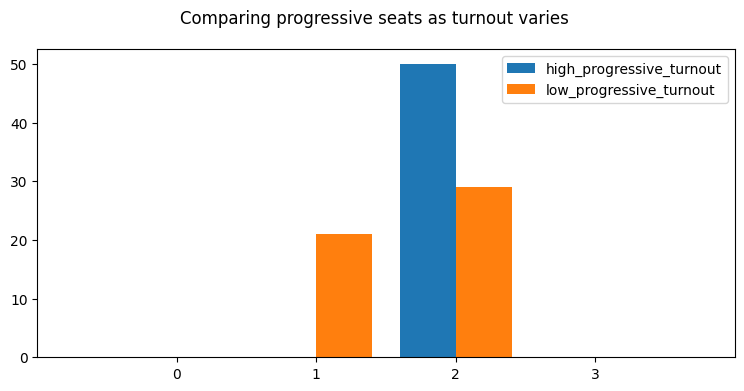

In [19]:
import matplotlib.pyplot as plt
import numpy as np

fig,ax = plt.subplots(figsize = (9,4))

bins = np.arange(-1/2, num_seats +1.5)

ax.hist(num_prog_winners_by_turnout.values(), label = num_prog_winners_by_turnout.keys(), bins = bins)
ax.set_xlim(-1, num_seats+1)
ax.set_xticks(range(0,num_seats+1))

plt.legend()

plt.suptitle("Comparing progressive seats as turnout varies")

Try it yourself

Using the code above as a skeleton, try to study the impact of high polarization. 

In [ ]:
from votekit.elections import STV
from tqdm.notebook import tqdm

num_cands = {"P": 3, "C": 3}
num_voters = 5000
num_seats = 3
num_trials = 50

# Fixed parameters
slate_to_candidates = {"P": [f"P_{i}" for i in range(num_cands["P"])],
                        "C": [f"C_{i}" for i in range(num_cands["C"])],}

cohesion_parameters = {
    "P": {"P":.8, "C":.2},
    "C": {"P":.2, "C":.8},
    }

alphas = { # the candidate strength
    "P": {"P":1, "C":1}, # all bets are off
    "C": {"P":1, "C":1},
    }


# Varying parameter
turnouts = {
    "high_progressive_turnout"  : {"P": .7, "C": .3},
    "low_progressive_turnout"  : {"P": .5, "C": .5},
    }



num_prog_winners_by_turnout = {
    "high_progressive_turnout": [],
    "low_progressive_turnout": [],
    }

for turnout_label, bloc_voter_prop in turnouts.items():
    print(turnout_label)
    for _ in tqdm(range(num_trials)):
        pl = slate_PlackettLuce.from_params(slate_to_candidates=slate_to_candidates,
                bloc_voter_prop=bloc_voter_prop,
                cohesion_parameters=cohesion_parameters,
                alphas=alphas)
        
        profile = pl.generate_profile(num_voters)

        e = STV(profile, m= num_seats)

        winners = e.get_elected()
        num_prog_winners = len([c for cand_set in winners for c in cand_set if "P_" in c])

        num_prog_winners_by_turnout[turnout_label].append(num_prog_winners)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig,ax = plt.subplots(figsize = (9,4))

bins = np.arange(-1/2, num_seats +1.5)

ax.hist(num_prog_winners_by_turnout.values(), label = num_prog_winners_by_turnout.keys(), bins = bins)
ax.set_xlim(-1, num_seats+1)
ax.set_xticks(range(0,num_seats+1))

plt.legend()

plt.suptitle("Comparing progressive seats as turnout varies")